Welcome in the KABL tutorial!
==========================


KABL is a free software to derive atmospheric boundary layer height from backscatter profiles measured by aerosol lidars or ceilometers.
It is based on K-means algorithm: it automatically groups the points of the profile and identify one these groups as the boundary layer.

This notebook intent to explain how to install the KABL software and how to use it.

Installation
----------------

We assume the package is installed as explained in the `README.md`.
To check if the installation is ready, try importing the following modules:

In [7]:
import numpy as np
%matplotlib inline
import netCDF4 as nc
import sklearn

In [8]:
sklearn.__version__

'0.20.3'

In [3]:
# Local packages
from kabl import core
from kabl import utils
from kabl import graphics

ModuleNotFoundError: No module named 'kabl'

The package
---------------

### Description

KABL package is located in the `kabl` directory. It contains 4 Python source codes :
  * `core.py`: module containing the core functions of KABL.
  * `utils.py`: module containing basic functions used in KABL and in graphics.
  * `graphics.py`: module containing all advanced graphics.
  * `ephemerid.py`: module to calculate sunrise and sunset from position. From [Michel Landers](https://michelanders.blogspot.com/2010/12/calulating-sunrise-and-sunset-in-python.html)

They depend on other famous Python packages.
Here is the dependency graph:

![Alt](KABL_dependency_graph.png)


The algorithm
------------------
The present notebook will go through all the steps of the KABL algorithm.
Here is a flowchart of the algorithm, that gives also the map of this notebook.

![Alt](KABL_flowchart.png)

The input data
=================
Data information
----------------------------

The KABL algorithm take in input only data coming from aerosol lidar.
Lidar data are stored in daily files (one file per day) at the NetCDF format.

The test file contains the data measured at Trappes (20km south of Paris, France), the 2nd of August 2018.
It is a clear day with a marked boundary layer cycle.

Names of the netCDF file follow the convention `DAILY_MPL_SITEID_YYYYMMDD.nc`, which is exploited by several functions to get some information.

In [2]:
path_to_testfile='/home/rieutordt/Donnees/KABL-data/TESTDATA_lidar_Trappes_20180802.nc'

The information about the location and the date of measurements are given by the function `where_and_when` from `utils.py`:

In [3]:
help(utils.where_and_when)
utils.where_and_when(path_to_testfile)

Help on function where_and_when in module utils:

where_and_when(datafile)
    Returns the location of the lidar and the day when the measures
    have been done from the name of the file. Files must be named using
    the convention:
            DAILY_MPL_SITEID_YYYYMMDD.nc
    
    TODO: (9/9/19) add more significant digits to latitude and longitude
    
    [IN]
        - datafile (str): path to file
        
    [OUT]
        - location (str): name of the place where the lidar was
        - day (datetime): day of the measurements
        - lat (float): latitude of the place where the lidar was
        - lon (float): longitude of the place where the lidar was



('Trappes', datetime.datetime(2018, 8, 2, 0, 0), 48.7742, 2.0103)

Visualise the data
----------------------------
To have a look at the data, you may use `quicklook_data` from `graphics.py` as such:

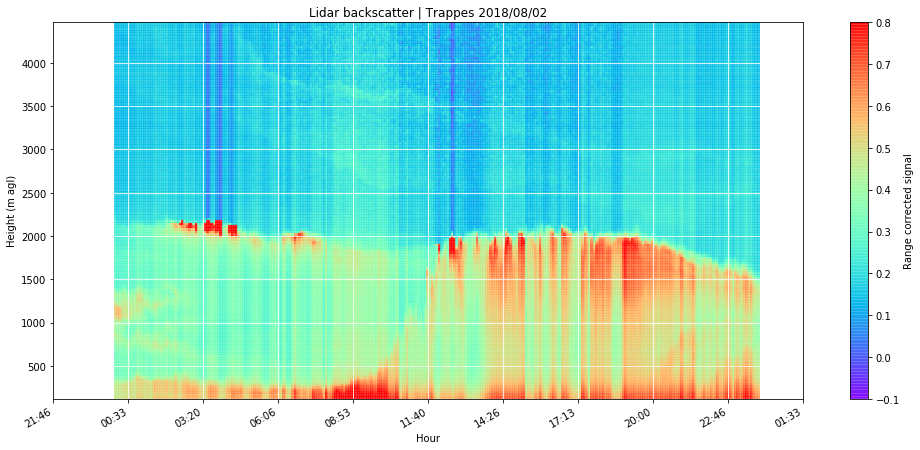

In [4]:
graphics.quicklook_data(path_to_testfile)

Access the data
-------------------------------
To access the data, you may use the function `extract_data` from `utils.py`. It takes in input the test file and it returns a tuple of at least 3 numpy.arrays:
  * vector of times
  * vector of altitudes
  * matrix of data
 
Other arguments are optional. They are use to specify which data you want to extract and to change the maximum range extracted.

In [5]:
help(utils.extract_data)

t_val,z_val,rcs_0,rcs_1,rcs_2=utils.extract_data(path_to_testfile)

print("t_val.shape=",t_val.shape,'z_val.shape=',z_val.shape,"rcs_0.shape=",rcs_0.shape,"rcs_1.shape=",rcs_1.shape)

Help on function extract_data in module utils:

extract_data(nc_file, to_extract=['rcs_0', 'rcs_1', 'rcs_2'], max_height=4500, params=None)
    Extract useful variables from the netcdf file into Numpy arrays
    with one line per time and one column per height.
    
    [IN]
        - nc_file (str): path to the netcdf file containing the data
        - to_extract (list of str): list of variables to extract. They must be the same as in the netcdf variables.
        - max_height (int): maximum altitude of measurement extracted.
        - params (dict): dict with all settings. If provided, the value params['max_height'] overrides the value given in 'max_height'.
    
    [OUT]
        - t (np.array[Nt]): vector of times
        - z (np.array[Nz]): vector of altitudes
        - *args (np.array[Nt,Nz]): measured atmospheric variable at all times and altitude

t_val.shape= (288,) z_val.shape= (146,) rcs_0.shape= (288, 146) rcs_1.shape= (288, 146)


One profile processing
======================
The K-means algorithm is applied to a single profile of aerosol backscatter.
Then, this processing is put into a loop on all the profiles of the day.
This section describes the operations done on a single profile, inside the loop.

Data preparation
-------------------------
First, the profile must be prepared: this step includes
  * The selection of the information used in the algorithm, given the time
  * The normalisation of the data

### Example

Let's consider one profile.
Test profiles have been preselected. They can be visualised thanks to the `quicklook_testprofiles` function.
We will use the one of 00:17 in the testfile and extract it thanks to the `extract_testprofile` function.

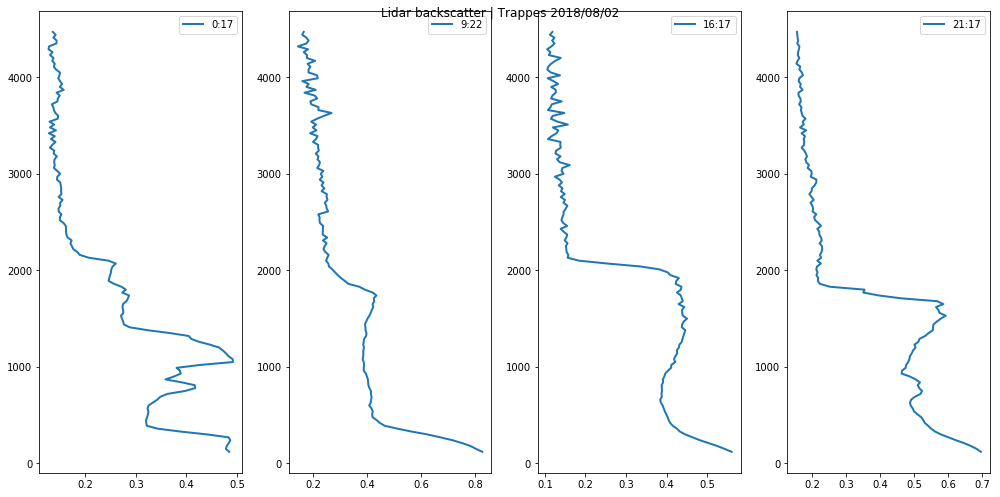

In [6]:
graphics.quicklook_testprofiles(path_to_testfile)

In [13]:
z_values,rcs_0ex,rcs_1ex,rcs_2ex,coords=utils.extract_testprofile(path_to_testfile,profile_id=0,return_coords=True)
print("z_values.shape",z_values.shape,"rcs_0.shape",rcs_0.shape,"rcs_2.shape",rcs_2.shape)

z_values.shape (146,) rcs_0.shape (288, 146) rcs_2.shape (288, 146)


The preparation of the data consist in forming a matrix $X$ with one line per observation and one column per atmospheric variable.
If we choose to include only the total range-corrected intensity, this matrix will be of size $146\times 1$.
If we choose to distinguish the two polarisation channels, this matrix will be of size $146\times 2$.

The default strategy is to use total range-corrected intensity at day and to distinguish both channels at night.
The distinction between day and night is made thanks to the `ephemerid.py` module.

In [24]:
from sklearn.preprocessing import StandardScaler

# Concatenation of atmospheric variables
X_test = np.array([rcs_1ex,rcs_2ex]).T

# Normalisation: remove mean and divide by standard deviation
scaler=StandardScaler()
scaler.fit(X_test)
X_test = scaler.transform(X_test)

X_test.shape

(146, 2)

### All in a function
The function `prepare_data` performs the same operation and also deals with the different predictors given the time.

In [25]:
X=core.prepare_data(coords,z_values,rcs_0ex,rcs_1ex,rcs_2ex)
print("max(|X-X_test|)=",np.max(np.abs(X-X_test)))
print("Are all elements equal?",(X==X_test).all())

max(|X-X_test|)= 0.0
Are all elements equal? True
